# Create `thaimaimeex` dataset for Text Classification and Regression

In [48]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import jenkspy
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [49]:
# #from https://gist.github.com/korakot/01d181229b21411b0a20784e0ca20d3d
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !pip install -U --pre matplotlib  
import matplotlib.font_manager as matfont
matfont.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
from plotnine import *
from mizani import *
theme_set(theme_minimal(14, 'TH Sarabun New'))

# #for mac
# import matplotlib
# matplotlib.rc('font', family='Ayuthaya')

## Create Targets

Possible targets `unit`, `ministry` and `budget`. For `budget`, we tried 2 alternatives for target creation: classification and regression.

In [78]:
thaime = pd.read_csv('data/thaimaimee.csv')[['project_name','budget','unit','ministry']].dropna()\
    .drop_duplicates().reset_index(drop=True)
thaime.shape

(32827, 4)

In [79]:
#use median budget for duplicate project names
thaime = thaime.groupby('project_name').agg({'budget': lambda x: np.percentile(x,50),'unit':max,'ministry':max}).reset_index()
thaime.tail()

,project_name,budget,unit,ministry
31496,“ผ่องานศิลป์ กินของยวน” ครบรอบ ๑๒ ปี ตลาดต้าน้...,1250000.0,สำนักงานปลัดกระทรวงการท่องเที่ยวและกีฬา,การท่องเที่ยวและกีฬา
31497,“มหกรรมลูกทุ่งซ่าส์ พัทยาแซ่บ” งาน “เทศกาลลูก...,30000000.0,เมืองพัทยา,มหาดไทย
31498,“สืบชะตาต้นยางนา ณ กาดฮิมน้ำ พระยาทด”,700000.0,สำนักงานปลัดกระทรวงการท่องเที่ยวและกีฬา,การท่องเที่ยวและกีฬา
31499,“สืบศิลป์ ถิ่นลาวเวียง”,500000.0,สำนักงานปลัดกระทรวงการท่องเที่ยวและกีฬา,การท่องเที่ยวและกีฬา
31500,“แพร่ในวันวาน” ชุมชนสืบสาน สู่การท่องเที่ยวสร้...,12000000.0,จังหวัดแพร่,มหาดไทย


In [80]:
thaime.project_name.nunique()

31501

### Jenks Natural Breaks for `budget_class` as Classification Target

We use Jenks natural breaks with optimal breaks found by elbow of [goodness-of-variance-fit](https://stats.stackexchange.com/questions/143974/jenks-natural-breaks-in-python-how-to-find-the-optimum-number-of-breaks) (breaks=4) for `budget_class`. The problem is most projects are under 7 billion baht meaning this will not be a balanced target.

In [62]:
budgets = np.array(thaime.budget)
gvfs = []
for i in tqdm(range(2,11)):
    gvfs.append(goodness_of_variance_fit(budgets,i))
elbow = pd.DataFrame({'breaks':range(2,11),'gvf':gvfs})
elbow

,breaks,gvf
0,2,0.739821
1,3,0.859010
2,4,0.918611
3,5,0.925350
4,6,0.933050
5,7,0.940711
6,8,0.943150
7,9,0.944466
8,10,0.945306


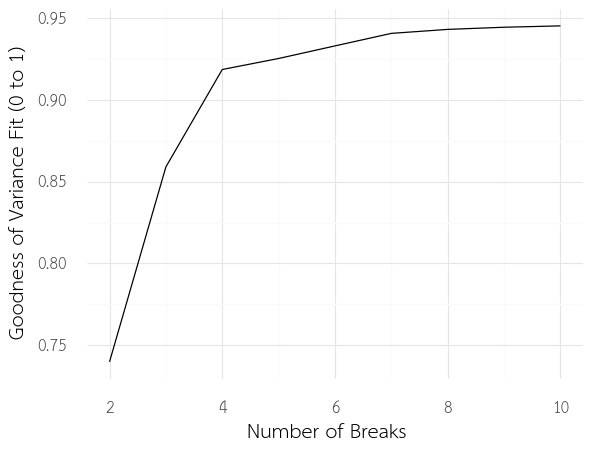

<ggplot: (-9223363269154898053)>

In [63]:
g = (ggplot(elbow, aes(x='breaks',y='gvf',group=1)) + geom_line() +
    xlab('Number of Breaks') + ylab('Goodness of Variance Fit (0 to 1)'))
g

In [64]:
opt_breaks = jenkspy.jenks_breaks(budgets,4)
[i/1e9 for i in opt_breaks]

[8.7e-06, 7.8, 26.2021344, 55.0, 100.0]

### `log_budget` as Regression Target

Another alternative is to frame it as a regression table but perform Box-cox transformation to make the budget distribution more normal. We can see that the coefficient of boxcox plot peaked at labmda = 0, meaning a log transformation is optimal for transforming budget to be more normal.

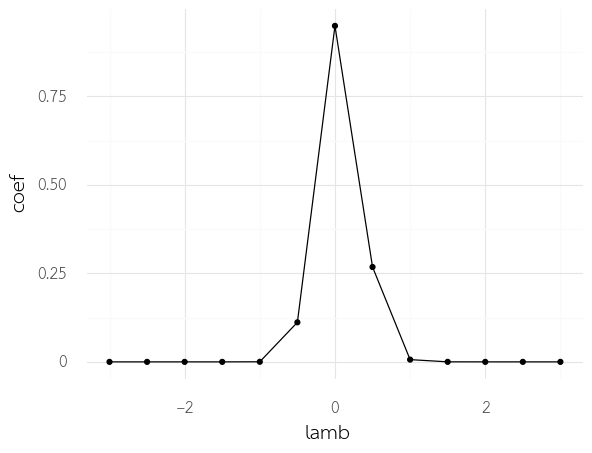

<ggplot: (-9223363269154654541)>

In [65]:
boxcox_plot(thaime,'budget')

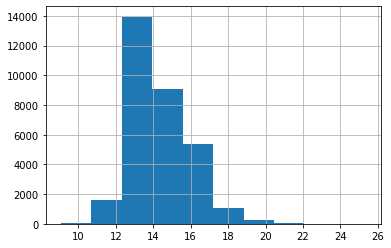

In [81]:
# thaime['log_budget'] = boxcox(thaime.budget,0)
thaime['log_budget'] = np.log(thaime.budget)
thaime = thaime.drop('budget',1)
thaime.log_budget.hist()

In [82]:
#MSE when predicting mean
np.mean((thaime.log_budget - thaime.log_budget.mean())**2)

2.5132841772316947

In [83]:
thaime = thaime.reset_index(drop=True)
thaime

,project_name,unit,ministry,log_budget
0,"""มะนาวพาสุข"" เพิ่มคุณภาพชีวิตคนพิการในจังหวัดส...",สำนักงานคณะกรรมการการศึกษาขั้นพื้นฐาน,ศึกษาธิการ,14.926842
1,-ก่อสร้างระบบประปาหมู่บ้าน แบบบาดาลขนาดกลาง ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,13.165423
2,-ก่อสร้างระบบประปาหมู่บ้าน แบบผิวดินขนาดกลาง ...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,14.437162
3,-ก่อสร้างระบบประปาหมู่บ้านพร้อมเจาะบ่อบาดาล ห...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,13.120361
4,-ก่อสร้างระบบประปาหมู่บ้านพร้อมเจาะบ่อบาดาล ห...,กรมส่งเสริมการปกครองท้องถิ่น,มหาดไทย,13.120361
...,...,...,...,...
31496,“ผ่องานศิลป์ กินของยวน” ครบรอบ ๑๒ ปี ตลาดต้าน้...,สำนักงานปลัดกระทรวงการท่องเที่ยวและกีฬา,การท่องเที่ยวและกีฬา,14.038654
31497,“มหกรรมลูกทุ่งซ่าส์ พัทยาแซ่บ” งาน “เทศกาลลูก...,เมืองพัทยา,มหาดไทย,17.216708
31498,“สืบชะตาต้นยางนา ณ กาดฮิมน้ำ พระยาทด”,สำนักงานปลัดกระทรวงการท่องเที่ยวและกีฬา,การท่องเที่ยวและกีฬา,13.458836
31499,“สืบศิลป์ ถิ่นลาวเวียง”,สำนักงานปลัดกระทรวงการท่องเที่ยวและกีฬา,การท่องเที่ยวและกีฬา,13.122363


## Train-test split

We perform 85/15 split for train (and dev) set and test set. The benchmark is calculated by mean squared error of the test set (codes must be shown to avoid overfitting test set). Seed is 1412.

In [93]:
np.random.seed(1412)
test_idx = np.random.choice(thaime.index,size=int(thaime.shape[0]*0.15), replace=False)
thaime['test_flag'] = 0
thaime.iloc[test_idx,4] = 1
thaime.test_flag.value_counts()

0    26776
1     4725
Name: test_flag, dtype: int64

In [94]:
#check stats
thaime.groupby('test_flag').log_budget.describe()

,count,mean,std,min,25%,50%,75%,max
test_flag,,,,,,,,
0,26776.0,14.275082,1.588562,9.071078,13.109278,13.974393,15.384126,25.328436
1,4725.0,14.256586,1.567162,9.888374,13.109683,13.955273,15.345039,22.227360


In [95]:
thaime.to_csv('data/thaimaimeex.csv',index=False)